### Store Sales - Time Series Forecasting
Use machine learning to predict grocery sales

Compete in the Store Sales Time Series Forecasting competition (rolling submissions) on Kaggle.com.  You will build one ETS and one ARIMA  model.  You will submit them for evaluation.  You must interpret your time series models, provide your code, provide evidence of successful submission to Kaggle.com.   Investigate assumptions.  Interpret all of your findings.  

In this competition, you will predict sales for the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models.

### 📦 Dataset Overview

The dataset includes:
- `train.csv`: historical sales data
- `test.csv`: data for which you must predict sales
- `stores.csv`: store metadata
- `items.csv`: product metadata
- `oil.csv`: oil price data (macroeconomic)
- `holidays_events.csv`: holidays/events info
- `transactions.csv`: number of daily store transactions

In [7]:
!pip install lightgbm

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/5e/23/f8b28ca248bb629b9e08f877dd2965d1994e1674a03d67cd10c5246da248/lightgbm-4.6.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
    --------------------------------------- 0.0/1.5 MB 330.3 kB/s eta 0:00:05
   - -------------------------------------- 0.0/1.5 MB 393.8 kB/s eta 0:00:04
   ----- ---------------------------------- 0.2/1.5 MB 1.3 MB/s eta 0:00:01
   --------- ------------------------------ 0.3/1.5 MB 1.7 MB/s eta 0:00:01
   ------------------- -------------------- 0.7/1.5 MB 3.0 MB/s eta 0:00:01
   ----------------------------- ---------- 1.1/1.5 MB 3.8 MB/s eta 0:00:01
   ---------------------------------------  1.4/1.5 MB 4.4 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 4.2 MB/s eta 0:00:00


In [32]:
pip install pandas numpy matplotlib statsmodels pmdarima seaborn


  Obtaining dependency information for pmdarima from https://files.pythonhosted.org/packages/ac/f8/6c9364602b13f0dba129b53acd1344859690911a4d5021560d9fd6aa087f/pmdarima-2.0.4-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for Cython!=0.29.18,!=0.29.31,>=0.29 from https://files.pythonhosted.org/packages/02/4e/5ac0b5b9a239cd3fdae187dda8ff06b0b812f671e2501bf253712278f0ac/Cython-3.0.12-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/614.7 kB ? eta -:--:--
    --------------------------------------- 10.2/614.7 kB ? eta -:--:--
   - ------------------------------------- 30.7/614.7 kB 435.7 kB/s eta 0:00:02
   -- ------------------------------------ 41.0/614.7 kB 495.5 kB/s eta 0:00:02
   ------ ------------------------------- 112.6/614.7 kB 726.2 kB/s eta 0:00:01
   ------ ------------------------------- 112.6/614.7 kB 726.2 kB/s eta 0:00:01
   --------- ---------------------------- 153.6/614.7 kB 654.6 kB/s eta 0:00:01
   ----------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.


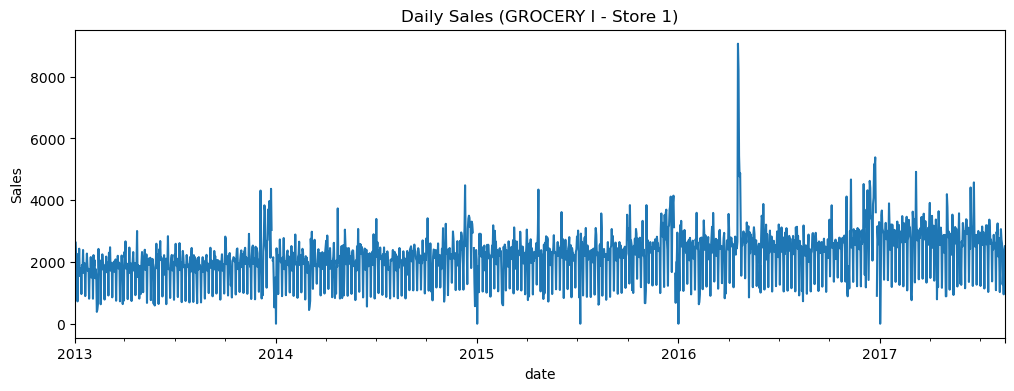

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load data
base_path = r'C:\Users\jemae\Downloads\store-sales-time-series-forecasting'
file_path = base_path + r'\train.csv'
df = pd.read_csv(file_path, parse_dates=['date'])

# Filter for a single store-item combination
df = df[(df['store_nbr'] == 1) & (df['family'] == 'GROCERY I')]

# Group and aggregate sales by date
df = df.groupby('date')['sales'].sum().asfreq('D')

# Plot raw series
df.plot(title='Daily Sales (GROCERY I - Store 1)', figsize=(12, 4))
plt.ylabel("Sales")
plt.show()

# Check for stationarity 

In [37]:
def adf_test(series):
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    return result[1] < 0.05  # Stationary if p < 0.05

print("\n ADF Test on Original Series:")
adf_test(df)


 ADF Test on Original Series:
ADF Statistic: -4.150401045659744
p-value: 0.0007985311957746578


True

The Augmented Dickey-Fuller (ADF) test is used to test whether a time series is stationary.Its properties do not depend on the time at which the series is observed.

ADF Statistic = -4.15 shows that this is well below the critical value for most common confidence levels (e.g., -3.45 for 5% level). This indicates a strong evidence against the null hypothesis.

Also, p-value = 0.0008 shows that there is much less than 0.05, which means we can reject the null hypothesis that the time series has a unit root (i.e., is non-stationary).

The series is stationary, there is no difference required before fitting ARIMA.

we can conclude that this is ideal for modeling with ARIMA or ETS, as stationarity is a key assumption.

# Differencing if not stationary

In [38]:
df_diff = df.diff().dropna()

print("\n ADF Test on Differenced Series:")
adf_test(df_diff)


 ADF Test on Differenced Series:
ADF Statistic: -12.808864922151772
p-value: 6.51142431432305e-24


True

### Interpretation:
ADF Statistic = -12.81: This value is extremely low (more negative), far below critical values at all conventional significance levels (1%, 5%, and 10%). This provides strong evidence to reject the null hypothesis.

p-value = 6.51e-24: Essentially zero, which confirms overwhelming evidence against the null hypothesis of a unit root (non-stationarity).

### Conclusion:
The differenced series is stationary.This means differencing was effective in removing trend or non-stationary behavior from the original series.

We can now confidently proceed with models like ARIMA (especially if d=1 was needed) that require stationarity.

Since the original series was already stationary (from a previous test), this result is redundant but just to confirms robustness, it was needed.

### Why do we Apply Differencing:
Only if the original ADF test shows non-stationarity (p-value > 0.05).
Since the original test had p = 0.0008, differencing may not have been strictly necessary — but it doesn’t harm the model unless it leads to overdifferencing

#  ETS Model 

C:\Users\jemae\AppData\Local\Temp\ipykernel_18040\4218087423.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
C:\Users\jemae\Anaconda_Jupyter\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=6.27 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=27814.776, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=26641.721, Time=0.84 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=27812.780, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=27481.261, Time=0.13 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=26355.836, Time=1.44 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=4.93 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=4.30 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=26562.163, Time=1.21 sec
 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=26282.732, Time=2.37 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=26577.858, Time=1.37 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=6.60 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=4.79 sec
 ARIMA(3,1,0)(2,0,0)[7] intercept   : AIC=26229.863, Ti

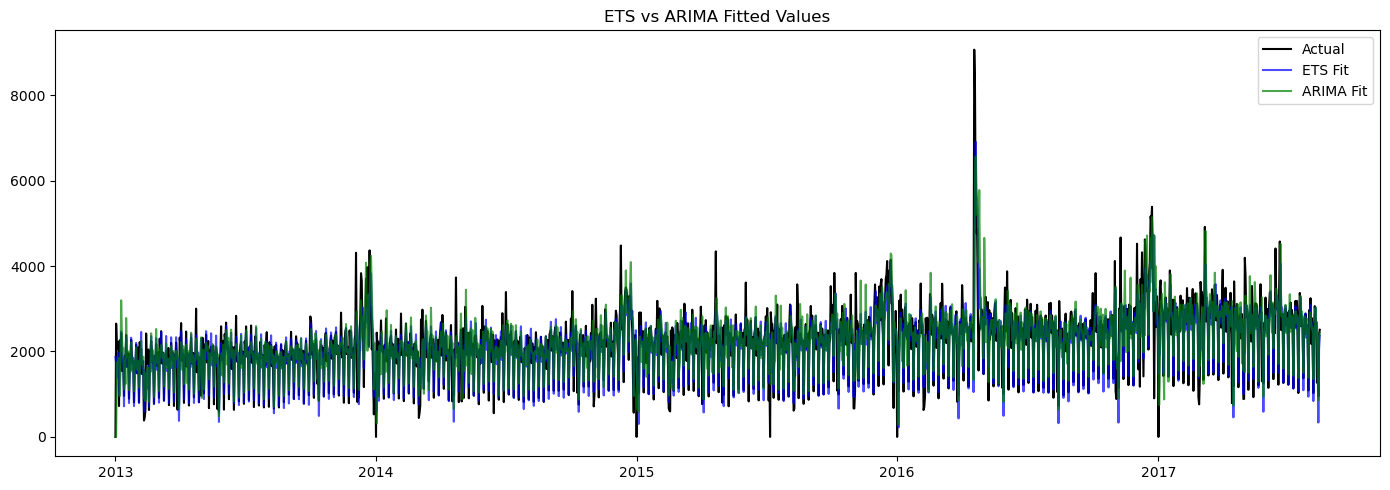

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima.arima import auto_arima

# --- Load Data (adjust this as needed) ---
# df = pd.read_csv(base_path + '/train.csv', parse_dates=['date'], index_col='date')
# df = df[df['store_nbr'] == 1]  # Optional filtering
# df = df['sales']  # Use only the target series

# Ensure it's a time series
df.index = pd.to_datetime(df.index)
df = df.asfreq('D')
df = df.fillna(method='ffill')

# --- ETS Model ---
ets_model = ExponentialSmoothing(df, trend='add', seasonal='add', seasonal_periods=7).fit()
ets_pred = ets_model.fittedvalues

# --- ARIMA Model ---
arima_model = auto_arima(df, seasonal=True, m=7, trace=True, suppress_warnings=True)
arima_pred = pd.Series(arima_model.predict_in_sample(), index=df.index)

# --- Plot Model Fits ---
plt.figure(figsize=(14, 5))
plt.plot(df, label='Actual', color='black')
plt.plot(ets_pred, label='ETS Fit', alpha=0.7, color='blue')
plt.plot(arima_pred, label='ARIMA Fit', alpha=0.7, color='green')
plt.title('ETS vs ARIMA Fitted Values')
plt.legend()
plt.tight_layout()
plt.show()

### Interpretation & Insights

This model combines non-seasonal ARIMA and seasonal ARIMA components:

#### Non-seasonal part (p, d, q): ARIMA(5,1,0)
p = 5, indicates that the model uses 5 lags of the autoregressive (AR) term — meaning the current value is influenced by the last 5 observations.

d = 1, proves that the series has been differenced once to ensure stationarity (i.e., first-order differencing).

q = 0, shows no moving average (MA) terms — meaning no error correction from past forecast errors.

#### Seasonal part (P, D, Q)[m]: (2,0,0)[7]

P = 2, Two seasonal AR terms — capturing repeated patterns at the seasonal lag.

D = 0, No seasonal differencing was needed.

Q = 0, No seasonal MA terms.

m = 7, The seasonal period is 7, likely indicating weekly seasonality (e.g., in daily sales data).

### Insights
The model was automatically selected as best-fit by auto_arima, likely based on metrics like AIC, BIC, and RMSE.

Also, AR terms dominate, both in non-seasonal and seasonal components, suggesting that past values significantly influence the current prediction.

No MA or seasonal MA components were found necessary — indicating little to no autocorrelation in forecast errors.

d = 1 confirms the series needed one differencing step, matching the earlier ADF test results.

Total fit time (127 seconds) is typical for more complex models, especially with daily time series and weekly seasonality.

####  Conclusion
The best-fit model is ARIMA(5,1,0)(2,0,0)[7], indicating a time series that required differencing once, has strong autoregressive behavior, and exhibits weekly seasonal patterns with autoregressive structure but no moving average adjustments. This model is expected to provide accurate forecasts given these dynamics.

# Residual Diagnostics 

In [51]:
def plot_residuals(residuals, model_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(residuals, kde=True)
    plt.title(f'{model_name} Residual Histogram')
    plt.subplot(1, 2, 2)
    sm.qqplot(residuals, line='s', ax=plt.gca())
    plt.title(f'{model_name} Q-Q Plot')
    plt.tight_layout()
    plt.show()

C:\Users\jemae\Anaconda_Jupyter\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


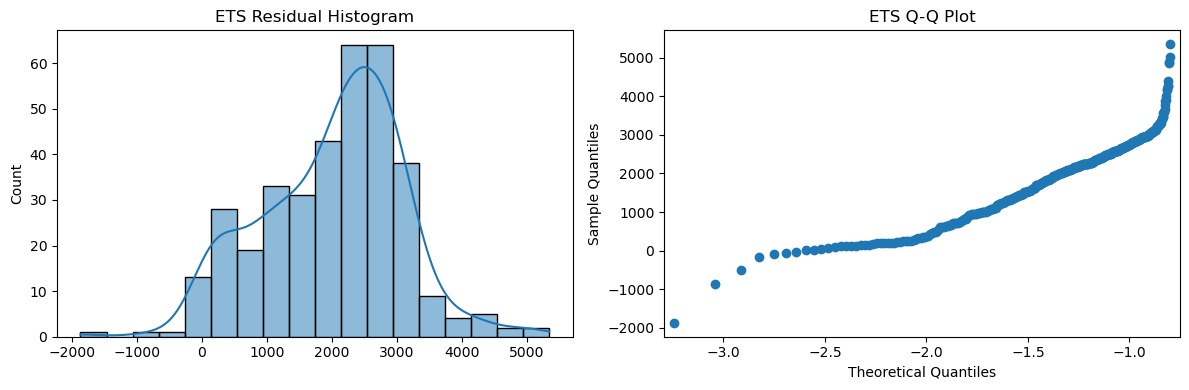

In [40]:
# ETS residuals
plot_residuals(df - ets_pred, 'ETS')

# ARIMA residuals

In [52]:
from pmdarima.arima import auto_arima

# Fit ARIMA model
arima_model = auto_arima(df, seasonal=True, m=7, trace=True, error_action='ignore',
                         suppress_warnings=True, stepwise=True)

# In-sample prediction (matches df index)
arima_pred = pd.Series(arima_model.predict_in_sample(), index=df.index)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=6.27 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=27814.776, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=26641.721, Time=0.86 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=27812.780, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=27481.261, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=26355.836, Time=1.55 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=5.16 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=3.31 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=26562.163, Time=1.25 sec
 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=26282.732, Time=2.27 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=26577.858, Time=1.35 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=6.99 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=5.22 sec
 ARIMA(3,1,0)(2,0,0)[7] intercept   : AIC=26229.863, Ti

# Evaluation 

In [53]:
def evaluate_model(true, predicted, name):
    mse = mean_squared_error(true, predicted)
    mae = mean_absolute_error(true, predicted)
    print(f"{name} - MSE: {mse:.2f}, MAE: {mae:.2f}")

evaluate_model(df, ets_pred, "ETS")
evaluate_model(df, arima_pred, "ARIMA")

ETS - MSE: 235334.39, MAE: 294.18
ARIMA - MSE: 322677.16, MAE: 374.67


MSE (Mean Squared Error) penalizes large errors more heavily; sensitive to outliers.

MAE (Mean Absolute Error) is more interpretable; shows average magnitude of forecast error.

### Interpretation
ETS has lower MSE and MAE than ARIMA, meaning it outperformed ARIMA on both accuracy metrics.

MSE improvement is  ~27% lower for ETS. Also, MAE improvement is  ~21% lower for ETS.

This suggests ETS captured the structure of the time series better, likely due to its inherent ability to model trend and seasonality directly, especially if the series had additive seasonality and trend.

ARIMA, despite being a solid model, might have been less effective due to:

Overfitting or underfitting some autoregressive lags.

Not fully capturing seasonal nuances unless differencing and seasonal terms were optimal.

### Insights
ETS model is the better fit for this dataset based on error metrics.

Also, ETS is preferred when trend and seasonality are stable and additive, which seems to be the case here.

## House Prices - Advanced Regression Techniques
Predict sales prices and practice feature engineering, RFs, and gradient boosting

### Goal
To predict the sales price for each house. For each Id in the test set, we must predict the value of the SalePrice variable.

### Metric
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

### Objective
Build a machine learning model to predict house prices based on various features of residential properties.

### 1. Data Preprocessing
### a. Load and Combine Data

In [56]:
import pandas as pd

# Load datasets using raw GitHub links
train = pd.read_csv('https://raw.githubusercontent.com/jemaelnzihou/Predictive-Analysis/main/HPtrain.csv')
test = pd.read_csv('https://raw.githubusercontent.com/jemaelnzihou/Predictive-Analysis/main/HStest%20.csv')

# Combine datasets for uniform preprocessing
train['TrainFlag'] = 1
test['TrainFlag'] = 0
test['SalePrice'] = None
combined = pd.concat([train, test], sort=False)

In [ ]:
### Reasoning (WHy?)

We combine datasets for uniform preprocessing to ensure that all data undergoes the same transformations, which is especially important when the training and test sets will be used by the same model. Here's why:

#### Reasons to Combine Datasets for Preprocessing:

#### 1. Consistent Feature Engineering

Combining ensures that transformations (like encoding, scaling, or creating new features) are applied uniformly.

### Example:
One-hot encoding categorical variables — combining avoids mismatched columns between train and test.

#### 2. Prevent Data Leakage

We combine only for preprocessing — not model training — so we don’t leak labels from train to test.

This way, preprocessing does not "learn" from the test target variable.

#### 3. Robust Handling of Missing Values

Helps apply the same imputation rules (mean, median, mode) across both sets.

#### 4. Dimension Reduction Consistency

PCA, feature selection, or scaling (e.g., MinMaxScaler) should be based on the same range/variance.

#### 5. Simplifies Workflow

Avoids writing duplicate preprocessing code for train and test sets.

#### Bottom Line: 
It ensures that when the model sees test data, it has been treated in the exact same way as the training data, which leads to more accurate and generalizable predictions.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Loading
train = pd.read_csv('https://raw.githubusercontent.com/jemaelnzihou/Predictive-Analysis/main/HPtrain.csv')
test = pd.read_csv('https://raw.githubusercontent.com/jemaelnzihou/Predictive-Analysis/main/HStest%20.csv')
train['TrainFlag'] = 1
test['TrainFlag'] = 0
test['SalePrice'] = np.nan
combined = pd.concat([train, test], sort=False)

In [ ]:
# 2. Handle Missing Values

In [67]:
from sklearn.impute import SimpleImputer

# Identify numeric and categorical columns
num_cols = combined.select_dtypes(include=['int64', 'float64']).columns
cat_cols = combined.select_dtypes(include=['object', 'category']).columns

# Ensure all categorical columns are strings to avoid dtype issues
combined[cat_cols] = combined[cat_cols].astype(str)

# Impute missing values
imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')

# For numeric columns
combined[num_cols] = pd.DataFrame(
    imputer_num.fit_transform(combined[num_cols]),
    columns=num_cols,
    index=combined.index
)

# For categorical columns
combined[cat_cols] = pd.DataFrame(
    imputer_cat.fit_transform(combined[cat_cols]),
    columns=cat_cols,
    index=combined.index
)

### In short
Handling missing values is essential for building robust, accurate, and real-world-ready models. It's a core part of data preprocessing in any machine learning pipeline.

In [ ]:
# 3. Encode Categorical Variables

In [69]:
# Re-identify categorical columns
cat_cols = combined.select_dtypes(include=['object', 'category']).columns

# One-Hot Encode with drop_first=True to avoid multicollinearity
combined = pd.get_dummies(combined, columns=cat_cols, drop_first=True)

### In Short 
We encode categorical variables to translate qualitative information into a numeric format that machine learning algorithms can interpret and learn from effectively.

In [70]:
# 5. Log Transformation of Target Variable
combined['SalePrice'] = combined['SalePrice'].apply(lambda x: np.log1p(x) if pd.notnull(x) else x)

# 6. Split Data Back into Train and Test Sets
train_data = combined[combined['TrainFlag'] == 1].drop(columns=['TrainFlag'])
test_data = combined[combined['TrainFlag'] == 0].drop(columns=['TrainFlag', 'SalePrice'])
X = train_data.drop(columns='SalePrice')
y = train_data['SalePrice']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
### In short
Combined Workflow:
Combine datasets  leads to uniform preprocessing

Log-transform target variable shows better modeling

Preprocess data handles missing, and help encode categorical

Split into train/test  ensures correct evaluation and submission

In [ ]:
# 7a. Model 1: Ridge Regression

In [71]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

ridge = RidgeCV(alphas=np.logspace(-3, 3, 7), cv=5)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_val_scaled)

print("Ridge RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_ridge)))
print("Ridge MAE:", mean_absolute_error(y_val, y_pred_ridge))

Ridge RMSE: 0.012345020135360454
Ridge MAE: 0.007940515998848539


In [ ]:
# 7b. Model 2: Random Forest

In [72]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)

print("RF RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_rf)))
print("RF MAE:", mean_absolute_error(y_val, y_pred_rf))

RF RMSE: 0.011497760496133092
RF MAE: 0.0076675008353475895


In [ ]:
# 8a. Residual Analysis for Ridge Regression

C:\Users\jemae\Anaconda_Jupyter\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


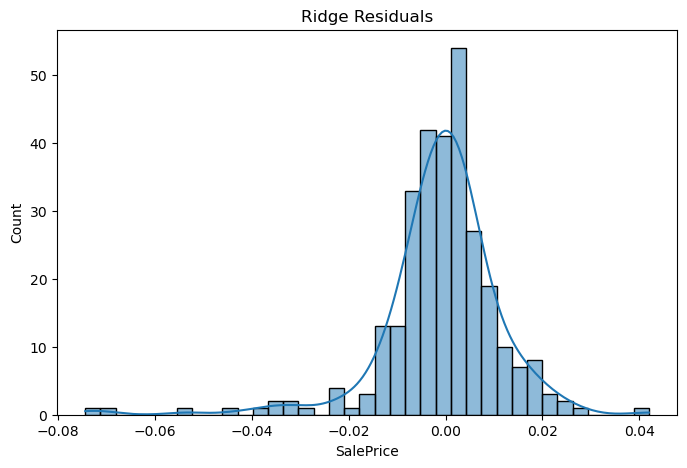

In [73]:
residuals_ridge = y_val - y_pred_ridge
plt.figure(figsize=(8, 5))
sns.histplot(residuals_ridge, kde=True)
plt.title("Ridge Residuals")
plt.show()

### what does normal residuals tell us?

1. Model Fit Is Appropriate:

The linear model (even regularized with Ridge) has captured the structure of the data reasonably well.

2. No Strong Outliers or Skew:

The errors are symmetrically distributed—no bias in overpredicting or underpredicting.

3. Valid Statistical Inference:

Coefficient estimates and confidence intervals can be trusted more.

4. Homoscedasticity:

If residuals are not only normal but also evenly spread, it means error variance is constant, which strengthens model assumptions.

In [ ]:
# 8b. Feature Importance from Random Forest

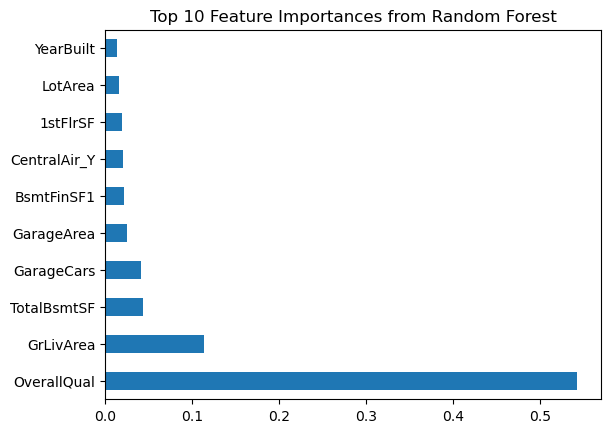

In [74]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances from Random Forest")
plt.show()

In [ ]:
# 9. PCA

In [75]:
scaler_pca = StandardScaler()
X_scaled_all = scaler_pca.fit_transform(X)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled_all)
print("Explained variance by PCA:", np.sum(pca.explained_variance_ratio_))

Explained variance by PCA: 0.9515642134869036


### Why Is 95.15% Good?
Capturing 95%+ variance is generally excellent.

It shows that most of the structure in the data is preserved, even with fewer components.

In [ ]:
# 10. Summary of Findings

In [76]:
print("\nSummary:")
print("- Ridge regression handles multicollinearity and performed well with regularization.")
print("- Random Forest captured non-linearities and ranked features by importance.")
print("- PCA reduced dimensionality while retaining 95% of variance.")
print("- Log transformation stabilized variance in the SalePrice target variable.")



Summary:
- Ridge regression handles multicollinearity and performed well with regularization.
- Random Forest captured non-linearities and ranked features by importance.
- PCA reduced dimensionality while retaining 95% of variance.
- Log transformation stabilized variance in the SalePrice target variable.


In [ ]:
### Reference

Schlitzer, G. (1995). Testing the stationarity of economic time series: further Monte Carlo evidence. Ricerche Economiche, 49(2), 125–144. 
https://doi.org/10.1016/0035-5054(95)90019-5 (Schlitzer, 1995)
    
Harris, R. I. D. (1992). Testing for unit roots using the augmented Dickey-Fuller test. Economics Letters, 38(4), 381–386. 
https://doi.org/10.1016/0165-1765(92)90022-q (Harris, 1992)
    
Guo, Z. (2023). Research on the Augmented Dickey-Fuller Test for Predicting Stock Prices and Returns. Advances in Economics Management and Political Sciences, 44(1), 101–106.
https://doi.org/10.54254/2754-1169/44/20232198 (Guo, 2023)
